# Quantum Alternating Operator Ansatz for Graph Coloring Problem with Qiskit
In this tutorial, we would like to explain the functionality while solving the Graph Coloring Problem using the Quantum Approximate Optimization Algorithm and the Quantum Alternating Operator Ansatz. This time, we are going to conduct simulations using qiskit.

In [1]:
from __future__ import annotations

import jijmodeling as jm
import jijmodeling_transpiler.core as jtc
import jijmodeling_transpiler_quantum.qiskit as jt_qk

from qiskit.primitives import Estimator, Sampler
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit import QuantumCircuit
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt

/tmp/ipykernel_28299/3484925615.py:8: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.minimum_eigensolvers import QAOA


First, we will implement the mathematical model of the graph coloring problem using JijModeling.

In [2]:
def graph_coloring_problem() -> jm.Problem:
    # define variables
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    N = jm.Placeholder("N")
    x = jm.BinaryVar("x", shape=(V, N))
    n = jm.Element("i", belong_to=(0, N))
    v = jm.Element("v", belong_to=(0, V))
    e = jm.Element("e", belong_to=E)
    # set problem
    problem = jm.Problem("Graph Coloring")
    # set one-hot constraint that each vertex has only one color

    problem += jm.Constraint("one-color", x[v, :].sum() == 1, forall=v)
    # set objective function: minimize edges whose vertices connected by edges are the same color
    problem += jm.sum([n, e], x[e[0], n] * x[e[1], n])
    return problem

In [3]:
problem = graph_coloring_problem()
problem

Next, we will create an instance of the problem.

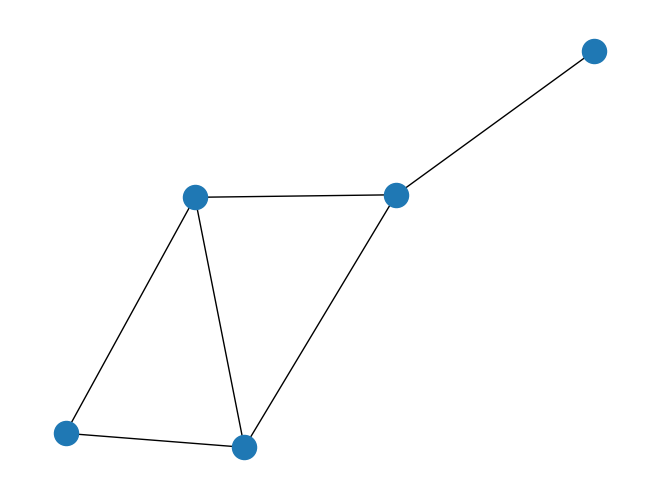

In [4]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (1, 2), (1, 3), (2, 3), (3, 4), (2, 4)])
nx.draw(G)

In [5]:
inst_E = [list(edge) for edge in G.edges]
color_num = 3
num_nodes = G.number_of_nodes()
instance_data = {"V": num_nodes, "N": color_num, "E": inst_E}
num_qubits = num_nodes * color_num

# Quantum Approximate Optimazation Algorithm (QAOA)
The Quantum Approximate Optimization Algorithm (QAOA) is one of the quantum optimization algorithms that use a variational quantum circuit. For a detailed explanation, please refer to paper [1], but here we will only give a rough overview.
In QAOA, a variational quantum circuit is constructed by applying the Ising Hamiltonian $H_P = \sum_{ij}J_{ij}Z_iZ_j$ and the $X$-mixer Hamiltonian $H_M = \sum_iX_i$ in the following way:
If we start with an initial state $|\psi_0\rangle$, then
$$|\psi(\beta,\gamma)\rangle = e^{-\beta_pH_M}e^{-\gamma_pH_P}\cdots e^{-\beta_1H_M}e^{-\gamma_1H_P}|\psi_0\rangle$$
can be written. Here, $\beta_k,\gamma_k$ are the parameters to be optimized, and since the operation $e^{-\beta_kH_M}e^{-\gamma_kH_P}$ is repeated $p$ times, there are a total of $2p$ parameters. In the standard QAOA, the total number of parameters is independent of the number of qubits and depends only on the number of repetitions.

Optimization of $\beta_k,\gamma_k$ is performed by repeating the following steps 1 and 2:

1. Compute the expectation value $\langle\psi(\beta,\gamma)|H_P|\psi(\beta,\gamma)\rangle$ on a quantum device.
2. Update the parameters on a classical computer to minimize the expectation value.

By repeating this calculation of the expectation value on the quantum computer and optimization of parameters on the classical computer, we obtain the minimum energy $\langle H_P \rangle$ and the corresponding final state. If we consider QAOA as a mathematical optimization algorithm, this minimum energy corresponds to the minimum objective function value, and the final state becomes the optimal solution.

## Implementing QAOA using JTQ
Now, let's try solving the Graph Coloring Problem using QAOA.
To execute QAOA, it's necessary to convert the mathematical model into an Ising Hamiltonian, and then create a variational quantum circuit and Hamiltonian using a quantum computing library. However, since JTQ supports QAOA, it allows for relatively easy execution.

First, using JijModeling-Transpiler, we create a CompiledInstance from JijModeling's mathematical model and instance data.

In [6]:
compiled_instance = jtc.compile_model(problem, instance_data)

Next, we create a QAOABuilder using JTQ's transpile_to_qaoa_ansatz. By setting the weight coefficients for the constraints on this Builder, we can create the Hamiltonian.

In [7]:
qaoa_builder = jt_qk.qaoa.transpile_to_qaoa_ansatz(compiled_instance,normalize=False,relax_method=jtc.pubo.RelaxationMethod.SquaredPenalty)
hamiltonian, _ = qaoa_builder.get_hamiltonian(multipliers={"one-color": 1})

Now that we have the variational quantum circuit and Hamiltonian ready, let's actually execute QAOA using Qiskit. Here, we will use `QAOA` from Qiskit's `minimum_eigensolvers` to carry out the QAOA.

In [8]:
sampler = Sampler()
optimizer = COBYLA()
qaoa = QAOA(sampler, optimizer, reps=1)

By using the `compute_minimum_eigenvalue method`, we can even perform the sampling of the final state.

In [9]:
result = qaoa.compute_minimum_eigenvalue(hamiltonian)

The `result.eigenstate` contains the sampling results of the quantum circuit. To make the results more readable, we use the `decode_from_quasi_dist` method to convert the results into a `jm.SampleSet`. This process automatically transforms the solution into the form formulated in the mathematical model and also calculates violations of constraints and the objective function value.

In [10]:
sampleset = qaoa_builder.decode_from_quasi_dist(result.eigenstate)

Finally, let's plot the results obtained from the sampling.

In [11]:
def plot_graph_coloring(graph: nx.Graph, sampleset: jm.SampleSet):
    # extract feasible solution
    feasibles = sampleset.feasible()
    if feasibles.evaluation.objective.size == 0:
        print("No feasible solution found ...")
    else:
        objectives = np.array(feasibles.evaluation.objective)
        lowest_index = np.argmin(objectives)

        # get indices of x = 1
        indices, _, _ = feasibles.record.solution["x"][lowest_index]
        # get vertices and colors
        sorted_vertices, sorted_colors = zip(
            *sorted(zip(*indices), key=lambda x: x[1])
        )
        # initialize vertex color list
        node_colors = [-1] * len(sorted_vertices)
        # set color list for visualization
        colorlist = ["gold", "violet", "limegreen", "darkorange"]
        # set vertex color list
        for i, j in zip(sorted_vertices, sorted_colors):
            node_colors[i] = colorlist[j]
        # make figure
        nx.draw_networkx(graph, node_color=node_colors, with_labels=True)
        plt.show()

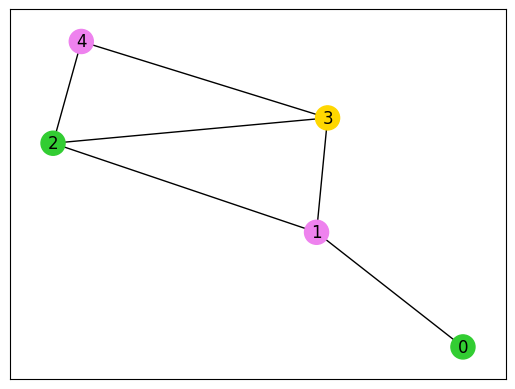

In [12]:
plot_graph_coloring(G, sampleset)

# Quantum Alternating Operator Ansatz
Next, let's try solving the graph coloring problem using the Quantum Alternating Operator Ansatz. The Quantum Alternating Operator Ansatz[2] is a modification of QAOA, where the mixer is changed from an $X$-mixer to a mixer tailored to the problem, ensuring that only solutions satisfying the constraints are searched for. For more detailed information, please refer to the original paper. Here, we will look at how to implement it in JTQ.

For the Graph Coloring problem, there is a one-hot constraint:
$$
\sum_k x_{v,k} = 1\quad \forall v
$$
However, turning this into an $XY$-mixer is the Quantum Alternating Operator Ansatz approach to the Graph Coloring problem.

First, we prepare a mathematical model excluding the constraints.

In [13]:
def graph_coloring_problem_wo_onehot() -> jm.Problem:
    # define variables
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    N = jm.Placeholder("N")
    x = jm.BinaryVar("x", shape=(V, N))
    n = jm.Element("i", belong_to=(0, N))
    v = jm.Element("v", belong_to=(0, V))
    e = jm.Element("e", belong_to=E)
    # set problem
    problem = jm.Problem("Graph Coloring without Onehot")
    # set one-hot constraint that each vertex has only one color
    problem += jm.sum([n, e], x[e[0], n] * x[e[1], n])
    return problem

In [14]:
problem = graph_coloring_problem_wo_onehot()
problem

Similar to before, we compile and create a Hamiltonian.

In [15]:
compiled_instance = jtc.compile_model(problem, instance_data)
qaoa_builder = jt_qk.qaoa.transpile_to_qaoa_ansatz(compiled_instance)
ising_operator, _ = qaoa_builder.get_hamiltonian()

Next, we will create an $XY$-mixer. The $XY$-mixer can be written as
$$
XY_{ij} = \frac{1}{2}\left(X_iX_j + Y_iY_j \right).
$$
This is an operator that swaps the bits 1 and 0 in bit $i,j$. Therefore, it can transform a bit string $100$, which satisfies the one-hot constraint, into another bit string $010$, which also satisfies the one-hot constraint.

Here, the only part under the one-hot constraint is related to color, so in terms of the mathematical model, we need to transform the bits between $x_{v0}$ and $x_{v1}$.
On the other hand, as these variables are usually embedded in qubits, it is necessary to remember which bit corresponds to which variable when constructing the algorithm and handle them appropriately.
In JTQ, the correspondence of variables is contained in var_map inside CompiledInstance.
```python
var_map['variable_name'][indices]
```
You can check which qubit corresponds to a variable in the mathematical model in this way.
Let's use this to create an $XY$-mixer.

What we want here is the transformation between $x_{v,k}$ and $x_{v,k+1}$, so we can obtain the index of the corresponding qubit by accessing compiled_instance.var_map.var_map["x"][(i,k)]."

In [16]:
from qiskit.circuit import Parameter

def create_xy_mixer(beta:Parameter,num_nodes:int,num_color:int, compiled_instance: jtc.CompiledInstance):
    n = num_color*num_nodes
    qc = QuantumCircuit(n)
    var_map = compiled_instance.var_map.var_map["x"]
    #even
    for i in range(num_nodes):
        for k in range(0,num_color-1,2):
            qc.rxx(beta,var_map[(i,k)],var_map[(i,k+1)])
            qc.ryy(beta,var_map[(i,k)],var_map[(i,k+1)])
            
    #odd
    for i in range(num_nodes):
        for k in range(1,num_color-1,2):
            qc.rxx(beta,var_map[(i,k)],var_map[(i,k+1)])
            qc.ryy(beta,var_map[(i,k)],var_map[(i,k+1)])
            
    # ini-last
    if num_color % 2 == 1:
        for i in range(num_nodes):
            qc.rxx(beta,var_map[(i,0)],var_map[(i,num_color-1)])
            qc.ryy(beta,var_map[(i,0)],var_map[(i,num_color-1)])
    return qc

In [17]:
def create_initial_state(compiled_instance: jtc.CompiledInstance, num_nodes: int,num_color:int):
    n = num_color*num_nodes
    qc = QuantumCircuit(n)
    var_map = compiled_instance.var_map.var_map["x"]
    for i in range(num_nodes):
        qc.x(var_map[(i, 0)])
    return qc

Now that the Ansatz has been created, we would like to run the Quantum Alternating Operator Ansatz.

In [18]:
sampler = Sampler()
optimizer = COBYLA()
initial_state = create_initial_state(compiled_instance, num_nodes,num_color=color_num)
xy_mixer = create_xy_mixer(Parameter("beta"), num_nodes, color_num, compiled_instance)
qaoa = QAOA(sampler, optimizer, reps=1,initial_state=initial_state,mixer=xy_mixer)

In [19]:
result = qaoa.compute_minimum_eigenvalue(ising_operator)

In [20]:
sampleset = qaoa_builder.decode_from_quasi_dist(result.eigenstate)

Let's plot the results obtained.

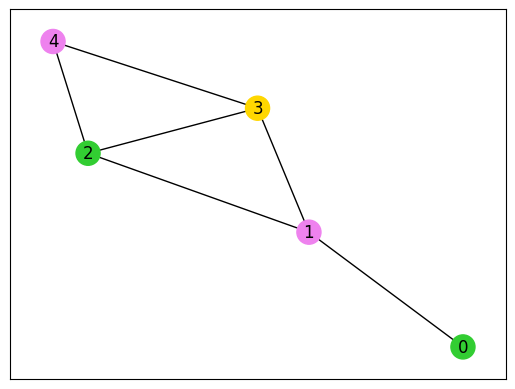

In [21]:
plot_graph_coloring(G, sampleset)

## References
[1] E. Farhi et al., "A Quantum Approximate Optimization Algorithm" arXiv (2014)
[2] S. Hadfield et al., "From the Quantum Approximate Optimization Algorithm to a Quantum Alternating Operator Ansatz", algorithms (2019)